In [6]:
import numpy as np
import rtree
from rtree import index
import import_ipynb

In [7]:
# - dataset: numpy array

def DatasetGenerator(dataset):
    #for i in range(3000000):
    for i in range(len(dataset)):
        yield(i, (dataset[i,0], dataset[i,1], dataset[i,0], dataset[i,1]), dataset[i])
        #yield(i, (dataset[i,0], dataset[i,1]), dataset[i])
    return

# Generate Rtree MBRs using Bulk Loading (STR version)
# Hilbert R-tree: An improved R-tree using fractals. VLDB 1994
# STR: A Simple and Efficient Algorithm for R-Tree Packing. ICDE 1997
def GenerateRtreePartitionUsingBulkLoading(dataset, maximum_capacity = 10000):
    
    p = index.Property()
    p.leaf_capacity = maximum_capacity # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.9
#     p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(dataset), properties = p)
    
    leaves = idx.leaves()
    dims = int(len(leaves[0][2])/2)
    
    MBRs = []
    for i in range(len(leaves)):
        mbr = leaves[i][2]
        interleaved_mbr = []
        for j in range(dims):
            interleaved_mbr.append(mbr[j])
            interleaved_mbr.append(mbr[j+dims])
        interleaved_mbr.append(len(leaves[i][1]))
        MBRs.append(interleaved_mbr)
                   
    MBRs = np.array(MBRs) 
    return MBRs

In [8]:
# reform the partition representation of RTree's MBR into NORA's kdnodes
# MBR[i, ...]: each line: L1. U1, L2, U2,...,Ln Un, Counts
# kdnodes[i][0/1][k][0/1]: i partitions, 0/1 boundary/count  k dimension  0/1 min/max
#
def PartitionFormalization(RTreePartition):
    
    dims = int(len(RTreePartition[0])/2)
    kdnodes = []
    for i in range(len(RTreePartition)):
        domains = []
        for k in range(dims):
            domains.append([ RTreePartition[i,2*k], RTreePartition[i,2*k+1] ])     
        kdnodes.append([domains, RTreePartition[i,-1]])
    return kdnodes

# rtree_partitions = genfromtxt('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Legacy/data/temp/RTreePartitions_M5K_Dim12.csv', delimiter=',')
# rtree_kdnodes = PartitionFormalization(rtree_partitions)

In [9]:
# check whether there are overlaps in between
def detect_overlap(kdnodes):
    count = 0
    for i in range(len(kdnodes)-1):
        for j in range(i+1, len(kdnodes), 1):
            overlap = True
            for d in range(len(kdnodes[i][0])):
                if kdnodes[i][0][d][0] >= kdnodes[j][0][d][1] or kdnodes[i][0][d][1] <= kdnodes[j][0][d][0]:
                    overlap = False
                    break
            if overlap:
                count += 1
                print("overlap detect:",i,j,kdnodes[i][0],kdnodes[j][0])
    print("total overlap pairs:",count)

In [11]:
# # Test Rtree Bulk Loading

# tiny_kdnodes = [ [[[0,10],[0,4]],13], [[[0,10],[4,10]],14] ]

# def DatasetGenerator(kdnodes):
#     for i in range(len(kdnodes)):
#         lower = [domain[0] for domain in kdnodes[i][0]]
#         upper = [domain[1] for domain in kdnodes[i][0]]
#         border = tuple(lower + upper) # non interleave
#         yield(i, border, kdnodes[i][1])
#     return

# p = index.Property()
# p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
# p.fill_factor = 0.5
# p.overwrite = True

# idx = index.Index(DatasetGenerator(tiny_kdnodes), properties = p)

# usage test
# print(idx.leaves())
# print(list(idx.intersection((1.0, 1.0, 2.0, 2.0))))
# print(list(idx.intersection((1.0, 5.0, 2.0, 7.0))))

# import copy
# copy_index = copy.deepcopy(idx)
# print(list(idx.intersection((1.0, 5.0, 2.0, 7.0))))
# copy_index.delete(1, (0,4,10,10))
# print(list(idx.intersection((1.0, 5.0, 2.0, 7.0))))
# print(list(copy_index.intersection((1.0, 5.0, 2.0, 7.0))))

In [2]:
# load the TWEET dataset
TWEET = np.genfromtxt('C:/Users/Cloud/Desktop/LearnIndex/data/SortedSingleDimPOIs2.csv', delimiter=',')
cols = [1, 0] # first lon then lat
TWEET_dataset = TWEET[:,cols]

In [3]:
np.savetxt('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/tweet_lon_lat.csv',TWEET_dataset)

In [245]:
len(TWEET_dataset)

1157570

In [4]:
scale_factor = 100
prob_threshold = 1 / scale_factor
total_dims = 16 # the dimensions of lineitem table
domain_dims = 8 # the dimensions we used and maintain min max for
chunk_size = 100000 # 0.1M 

# base_table_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/9a84f6cd-727f-4f10-ae95-10a0214e10a4-tpc-h-tool/2.18.0_rc2/dbgen/lineitem_'
# table_path = base_table_path + str(scale_factor) + '.tbl'

base_save_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/lineitem_'
save_path_data = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '.csv'
save_path_domain = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '_domains.csv'

# by default, the sampled size always equal to 6M (i.e., using scale factor 1), then for a higher scale factor, we need to divide it
block_size = 1000000 // scale_factor # in original file, 1M rows take approximately 128MB

# = = = Data Loading = = =
dataset = np.genfromtxt(save_path_data, delimiter=',') # the sampled subset
domains = np.genfromtxt(save_path_domain, delimiter=',') # the domain of that scale

# Configuration
used_dimensions = [1,2] # the second and third dimensions
# used_dimensions = [1,2,3] # the second, third and fourth dimensions

dataset = dataset[:,used_dimensions]
domains = domains[used_dimensions]

In [30]:
dataset.shape

(6001309, 2)

In [238]:
# Insert one by one
p2 = rtree.index.Property()
p2.leaf_capacity = data_threshold
p2.overwrite = True
p2.fill_factor = 0.9
idx2 = index.Index(properties = p2)
# for i in range(3000000):
#     if i % 10000 == 0:
#         print("current:",i)
#     idx2.insert(i, (dataset[i,0], dataset[i,1]))

for i in range(len(TWEET_dataset)):
    if i % 10000 == 0:
        print("current:",i)
    idx2.insert(i, (TWEET_dataset[i,0], TWEET_dataset[i,1]))

current: 0
current: 10000
current: 20000
current: 30000
current: 40000
current: 50000
current: 60000
current: 70000
current: 80000
current: 90000
current: 100000
current: 110000
current: 120000
current: 130000
current: 140000
current: 150000
current: 160000
current: 170000
current: 180000
current: 190000
current: 200000
current: 210000
current: 220000
current: 230000
current: 240000
current: 250000
current: 260000
current: 270000
current: 280000
current: 290000
current: 300000
current: 310000
current: 320000
current: 330000
current: 340000
current: 350000
current: 360000
current: 370000
current: 380000
current: 390000
current: 400000
current: 410000
current: 420000
current: 430000
current: 440000
current: 450000
current: 460000
current: 470000
current: 480000
current: 490000
current: 500000
current: 510000
current: 520000
current: 530000
current: 540000
current: 550000
current: 560000
current: 570000
current: 580000
current: 590000
current: 600000
current: 610000
current: 620000
curren

In [239]:
print(len(idx2.leaves()))
# for i in range(len(idx2.leaves())):
#     print(i,idx2.leaves()[i][2])

194


In [240]:
# get MBRs from leaves
dims = 2
MBRs = []
leaves = idx2.leaves()
for i in range(len(leaves)):
    mbr = leaves[i][2]
    interleaved_mbr = []
    for j in range(dims):
        interleaved_mbr.append(mbr[j])
        interleaved_mbr.append(mbr[j+dims])
    interleaved_mbr.append(len(leaves[i][1]))
    MBRs.append(interleaved_mbr)

MBRs = np.array(MBRs) 

In [241]:
# convert MBRs to kdnodes
rtree_kdnodes2 = PartitionFormalization(MBRs)

In [242]:
detect_overlap(rtree_kdnodes2)

total overlap pairs: 0


<IPython.core.display.Javascript object>


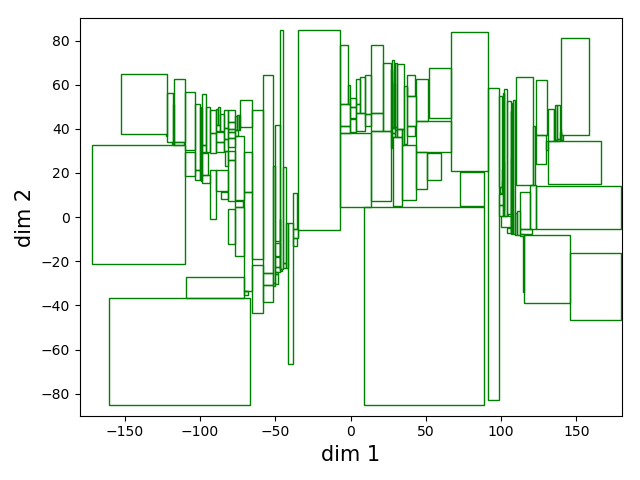

In [244]:
from Utils import *
#visualize_kdnodes_and_query_2(rtree_kdnodes2, [], [], domains)
visualize_kdnodes_and_query_2(rtree_kdnodes2, [], [], [[-180,180],[-90, 90]])

In [10]:
# try use bulkloading for the same dataset
data_threshold = block_size
BulkLoadMBRs = GenerateRtreePartitionUsingBulkLoading(dataset, maximum_capacity = data_threshold)
# BulkLoadMBRs = GenerateRtreePartitionUsingBulkLoading(TWEET_dataset, maximum_capacity = data_threshold)
print(BulkLoadMBRs)

[[3.4999950e+06 8.0367700e+06 2.0000000e+00 3.6955000e+04 9.0000000e+03]
 [4.5000000e+01 1.9787150e+07 3.0000000e+00 3.7262000e+04 9.0000000e+03]
 [4.2500590e+06 8.7875750e+06 5.0000000e+00 3.7600000e+04 9.0000000e+03]
 ...
 [1.3711564e+07 1.8249828e+07 9.6157400e+05 9.9999500e+05 9.0000000e+03]
 [1.2724192e+07 1.7249892e+07 9.6190900e+05 1.0000000e+06 9.0000000e+03]
 [1.4962924e+07 1.9499912e+07 9.6247200e+05 9.9999700e+05 9.0000000e+03]]


In [11]:
# convert to kdnode format
rtree_kdnodes = PartitionFormalization(BulkLoadMBRs)

In [12]:
# check overlap
detect_overlap(rtree_kdnodes)

overlap detect: 0 1 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[45.0, 19787150.0], [3.0, 37262.0]]
overlap detect: 0 2 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[4250059.0, 8787575.0], [5.0, 37600.0]]
overlap detect: 0 3 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[4750029.0, 9287820.0], [1.0, 37858.0]]
overlap detect: 0 4 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[153.0, 19783419.0], [2.0, 37905.0]]
overlap detect: 0 5 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[32.0, 19787761.0], [1.0, 37910.0]]
overlap detect: 0 6 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[133.0, 19788088.0], [12.0, 38134.0]]
overlap detect: 0 7 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[25.0, 19787992.0], [7.0, 38235.0]]
overlap detect: 0 8 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[3000083.0, 7538416.0], [5.0, 38458.0]]
overlap detect: 0 9 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[5512928.0, 10038801.0], [3.0, 38809.0]]
overlap detect: 0 10 [[3499995.0, 8036770.0], [2.0, 36955.0]] [[6760818.0, 11288606.0], [2.0, 3883

overlap detect: 19 548 [[38046.0, 19825429.0], [37916.0, 75458.0]] [[13788989.0, 18078641.0], [39000.0, 78675.0]]
overlap detect: 19 549 [[38046.0, 19825429.0], [37916.0, 75458.0]] [[17059533.0, 19868820.0], [59534.0, 118853.0]]
overlap detect: 20 21 [[38197.0, 19825901.0], [38137.0, 75928.0]] [[38259.0, 19826501.0], [38237.0, 76547.0]]
overlap detect: 20 22 [[38197.0, 19825901.0], [38137.0, 75928.0]] [[3038529.0, 7576312.0], [38459.0, 76519.0]]
overlap detect: 20 23 [[38197.0, 19825901.0], [38137.0, 75928.0]] [[6788926.0, 11326296.0], [38846.0, 76474.0]]
overlap detect: 20 24 [[38197.0, 19825901.0], [38137.0, 75928.0]] [[5538812.0, 10077338.0], [38809.0, 77475.0]]
overlap detect: 20 25 [[38197.0, 19825901.0], [38137.0, 75928.0]] [[819778.0, 5328883.0], [39267.0, 78899.0]]
overlap detect: 20 26 [[38197.0, 19825901.0], [38137.0, 75928.0]] [[2288962.0, 6579365.0], [38965.0, 79539.0]]
overlap detect: 20 27 [[38197.0, 19825901.0], [38137.0, 75928.0]] [[40620.0, 19829109.0], [40470.0, 79132

overlap detect: 46 403 [[2117573.0, 6654910.0], [117522.0, 154982.0]] [[154770.0, 19942761.0], [154771.0, 192911.0]]
overlap detect: 47 48 [[7618610.0, 12156019.0], [118371.0, 156041.0]] [[6902201.0, 11440072.0], [152207.0, 190171.0]]
overlap detect: 47 49 [[7618610.0, 12156019.0], [118371.0, 156041.0]] [[5653070.0, 10189412.0], [153007.0, 191433.0]]
overlap detect: 47 50 [[7618610.0, 12156019.0], [118371.0, 156041.0]] [[4402521.0, 8692566.0], [152516.0, 192618.0]]
overlap detect: 47 51 [[7618610.0, 12156019.0], [118371.0, 156041.0]] [[3403453.0, 7941984.0], [153409.0, 192117.0]]
overlap detect: 47 55 [[7618610.0, 12156019.0], [118371.0, 156041.0]] [[4655942.0, 9192979.0], [154977.0, 193014.0]]
overlap detect: 47 385 [[7618610.0, 12156019.0], [118371.0, 156041.0]] [[113339.0, 19900460.0], [113309.0, 150603.0]]
overlap detect: 47 386 [[7618610.0, 12156019.0], [118371.0, 156041.0]] [[112867.0, 19902759.0], [112814.0, 152842.0]]
overlap detect: 47 387 [[7618610.0, 12156019.0], [118371.0, 

overlap detect: 51 55 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[4655942.0, 9192979.0], [154977.0, 193014.0]]
overlap detect: 51 56 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[7656039.0, 12194351.0], [156051.0, 194424.0]]
overlap detect: 51 57 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[6940171.0, 11440247.0], [190173.0, 229847.0]]
overlap detect: 51 61 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[5691591.0, 9981330.0], [191435.0, 231619.0]]
overlap detect: 51 392 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[116506.0, 19904691.0], [116478.0, 154771.0]]
overlap detect: 51 393 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[115803.0, 19905087.0], [115795.0, 155617.0]]
overlap detect: 51 394 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[117076.0, 19905253.0], [117034.0, 155306.0]]
overlap detect: 51 396 [[3403453.0, 7941984.0], [153409.0, 192117.0]] [[150842.0, 19938335.0], [150612.0, 188445.0]]
overlap detect: 51 397 [[3403453.0, 7941984.0], [153409.0, 192117.

overlap detect: 74 434 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[11519666.0, 16057766.0], [269674.0, 307808.0]]
overlap detect: 74 435 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[8045972.0, 12558383.0], [269164.0, 308480.0]]
overlap detect: 74 436 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[12302237.0, 16808991.0], [269087.0, 309042.0]]
overlap detect: 74 437 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[7770579.0, 12302096.0], [270500.0, 307914.0]]
overlap detect: 74 438 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[9519971.0, 13810532.0], [269985.0, 310580.0]]
overlap detect: 74 569 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[13729504.0, 18254348.0], [229330.0, 267347.0]]
overlap detect: 74 570 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[14980668.0, 19518689.0], [230321.0, 268796.0]]
overlap detect: 74 571 [[16797.0, 19804695.0], [266798.0, 304772.0]] [[14013845.0, 18519680.0], [230009.0, 269742.0]]
overlap detect: 74 572 [[16797.0, 19804695.0], [266798.0, 3

overlap detect: 78 82 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[3019653.0, 7557482.0], [269270.0, 307579.0]]
overlap detect: 78 83 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[1018434.0, 5308851.0], [268331.0, 308904.0]]
overlap detect: 78 84 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[6769908.0, 11307641.0], [269655.0, 307744.0]]
overlap detect: 78 85 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[4270068.0, 8808184.0], [269859.0, 308459.0]]
overlap detect: 78 86 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[5521582.0, 10058942.0], [271481.0, 308997.0]]
overlap detect: 78 87 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[22903.0, 19810758.0], [272554.0, 310964.0]]
overlap detect: 78 88 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[54826.0, 19842654.0], [304774.0, 342870.0]]
overlap detect: 78 89 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[56132.0, 19567359.0], [306055.0, 343265.0]]
overlap detect: 78 90 [[18434.0, 19806603.0], [268194.0, 306643.0]] [[56328.0, 19

overlap detect: 101 447 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[93029.0, 19880945.0], [342875.0, 381047.0]]
overlap detect: 101 448 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[10343867.0, 14865564.0], [343868.0, 382567.0]]
overlap detect: 101 449 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[94523.0, 19883628.0], [344346.0, 383846.0]]
overlap detect: 101 578 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[13578735.0, 18095005.0], [306431.0, 345114.0]]
overlap detect: 101 579 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[17046476.0, 19856780.0], [296380.0, 356853.0]]
overlap detect: 101 580 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[14058178.0, 18595347.0], [308189.0, 345579.0]]
overlap detect: 101 581 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[12807963.0, 17345909.0], [307952.0, 346096.0]]
overlap detect: 101 582 [[93276.0, 19354861.0], [343267.0, 380716.0]] [[15058155.0, 19348023.0], [308032.0, 348135.0]]
overlap detect: 101 583 [[93276.0, 19354861.0], [34326

overlap detect: 128 307 [[7675157.0, 12212643.0], [425115.0, 462671.0]] [[211174.0, 19999033.0], [461175.0, 499074.0]]
overlap detect: 128 308 [[7675157.0, 12212643.0], [425115.0, 462671.0]] [[11461679.0, 15999282.0], [461680.0, 499489.0]]
overlap detect: 128 309 [[7675157.0, 12212643.0], [425115.0, 462671.0]] [[212491.0, 19999929.0], [462352.0, 500026.0]]
overlap detect: 129 130 [[925114.0, 5462725.0], [424998.0, 462936.0]] [[3460666.0, 7998258.0], [460579.0, 498343.0]]
overlap detect: 129 131 [[925114.0, 5462725.0], [424998.0, 462936.0]] [[2211230.0, 6748272.0], [461080.0, 498327.0]]
overlap detect: 129 133 [[925114.0, 5462725.0], [424998.0, 462936.0]] [[4710914.0, 9249348.0], [460758.0, 499452.0]]
overlap detect: 129 134 [[925114.0, 5462725.0], [424998.0, 462936.0]] [[2961962.0, 7499740.0], [461907.0, 499785.0]]
overlap detect: 129 290 [[925114.0, 5462725.0], [424998.0, 462936.0]] [[169106.0, 19958701.0], [419066.0, 458740.0]]
overlap detect: 129 292 [[925114.0, 5462725.0], [424998.

overlap detect: 156 332 [[2288030.0, 6577586.0], [537925.0, 577786.0]] [[74317.0, 19863459.0], [574279.0, 613524.0]]
overlap detect: 156 333 [[2288030.0, 6577586.0], [537925.0, 577786.0]] [[75281.0, 19862819.0], [575244.0, 612988.0]]
overlap detect: 156 337 [[2288030.0, 6577586.0], [537925.0, 577786.0]] [[76421.0, 19866479.0], [576306.0, 616554.0]]
overlap detect: 157 158 [[6789242.0, 11327134.0], [539259.0, 577283.0]] [[39616.0, 19827753.0], [539587.0, 577820.0]]
overlap detect: 157 159 [[6789242.0, 11327134.0], [539259.0, 577283.0]] [[4289858.0, 8827954.0], [539822.0, 577979.0]]
overlap detect: 157 160 [[6789242.0, 11327134.0], [539259.0, 577283.0]] [[5540250.0, 10077996.0], [540086.0, 578051.0]]
overlap detect: 157 162 [[6789242.0, 11327134.0], [539259.0, 577283.0]] [[74953.0, 19589768.0], [574954.0, 611728.0]]
overlap detect: 157 163 [[6789242.0, 11327134.0], [539259.0, 577283.0]] [[4825471.0, 9325999.0], [575372.0, 614727.0]]
overlap detect: 157 164 [[6789242.0, 11327134.0], [5392

overlap detect: 182 352 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[116596.0, 19904739.0], [616556.0, 654999.0]]
overlap detect: 182 354 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[150363.0, 19938697.0], [650364.0, 688898.0]]
overlap detect: 182 355 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[8152505.0, 12689517.0], [652424.0, 689644.0]]
overlap detect: 182 356 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[153615.0, 19941242.0], [653519.0, 691309.0]]
overlap detect: 182 358 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[153928.0, 19941537.0], [653843.0, 691640.0]]
overlap detect: 182 451 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[152774.0, 19943493.0], [652741.0, 693556.0]]
overlap detect: 182 453 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[155134.0, 19943013.0], [655000.0, 693071.0]]
overlap detect: 182 455 [[4402798.0, 8692194.0], [652663.0, 692289.0]] [[8189662.0, 12724093.0], [689644.0, 727136.0]]
overlap detect: 182 456 [[4402798.0, 8692194.0], [6526

overlap detect: 209 640 [[18599.0, 19806576.0], [768569.0, 806585.0]] [[15019195.0, 19536722.0], [769169.0, 807883.0]]
overlap detect: 209 641 [[18599.0, 19806576.0], [768569.0, 806585.0]] [[17022659.0, 19832703.0], [772641.0, 832704.0]]
overlap detect: 209 642 [[18599.0, 19806576.0], [768569.0, 806585.0]] [[12805945.0, 17343758.0], [805935.0, 844006.0]]
overlap detect: 210 211 [[3018931.0, 7556315.0], [768809.0, 806498.0]] [[4269178.0, 8806401.0], [769071.0, 806477.0]]
overlap detect: 210 212 [[3018931.0, 7556315.0], [768809.0, 806498.0]] [[18955.0, 19806667.0], [768932.0, 806669.0]]
overlap detect: 210 213 [[3018931.0, 7556315.0], [768809.0, 806498.0]] [[5519227.0, 10056601.0], [769219.0, 806736.0]]
overlap detect: 210 214 [[3018931.0, 7556315.0], [768809.0, 806498.0]] [[6769669.0, 11306749.0], [769621.0, 806794.0]]
overlap detect: 210 215 [[3018931.0, 7556315.0], [768809.0, 806498.0]] [[19408.0, 19807776.0], [769345.0, 807840.0]]
overlap detect: 210 216 [[3018931.0, 7556315.0], [768

overlap detect: 214 226 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[56682.0, 19845028.0], [806669.0, 845030.0]]
overlap detect: 214 227 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[4806427.0, 9325988.0], [806387.0, 845777.0]]
overlap detect: 214 479 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[123.0, 19999995.0], [731973.0, 770262.0]]
overlap detect: 214 480 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[8046051.0, 12556655.0], [767238.0, 806694.0]]
overlap detect: 214 481 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[9018700.0, 13556605.0], [768715.0, 806629.0]]
overlap detect: 214 483 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[10269466.0, 14807037.0], [769444.0, 807459.0]]
overlap detect: 214 484 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[9518939.0, 13808510.0], [768892.0, 808580.0]]
overlap detect: 214 485 [[6769669.0, 11306749.0], [769621.0, 806794.0]] [[7769421.0, 12302049.0], [769405.0, 808132.0]]
overlap detect: 214 488 [[6769669.0, 11306749.

overlap detect: 241 242 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[2099807.0, 6637336.0], [849549.0, 887363.0]]
overlap detect: 241 243 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[5632561.0, 10170748.0], [882567.0, 920844.0]]
overlap detect: 241 244 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[4381964.0, 8893291.0], [881938.0, 921680.0]]
overlap detect: 241 245 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[6883647.0, 11420581.0], [883250.0, 920960.0]]
overlap detect: 241 246 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[3132750.0, 7423443.0], [882740.0, 923489.0]]
overlap detect: 241 247 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[4655982.0, 9174134.0], [885571.0, 924285.0]]
overlap detect: 241 248 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[886106.0, 5423976.0], [886040.0, 924035.0]]
overlap detect: 241 249 [[3365044.0, 7886861.0], [848322.0, 886893.0]] [[7636268.0, 12174321.0], [886091.0, 924386.0]]
overlap detect: 241 495 [[3365044.0, 7886861.0], [8483

overlap detect: 245 500 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[8095256.0, 12633410.0], [845232.0, 883559.0]]
overlap detect: 245 501 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[9095373.0, 13385071.0], [845333.0, 885188.0]]
overlap detect: 245 502 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[96254.0, 19884183.0], [846227.0, 884308.0]]
overlap detect: 245 504 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[9347617.0, 13886131.0], [847542.0, 886149.0]]
overlap detect: 245 505 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[97498.0, 19886221.0], [847496.0, 886222.0]]
overlap detect: 245 506 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[130398.0, 19919649.0], [880387.0, 919889.0]]
overlap detect: 245 507 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[132022.0, 19919503.0], [881883.0, 919841.0]]
overlap detect: 245 508 [[6883647.0, 11420581.0], [883250.0, 920960.0]] [[8133551.0, 12671294.0], [883560.0, 921351.0]]
overlap detect: 245 510 [[6883647.0, 11420581.

overlap detect: 274 443 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[7807905.0, 12097551.0], [307916.0, 347612.0]]
overlap detect: 274 444 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[12309048.0, 16847185.0], [309047.0, 347233.0]]
overlap detect: 274 445 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[61018.0, 19848378.0], [310967.0, 348442.0]]
overlap detect: 274 446 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[9326061.0, 13849566.0], [310581.0, 349619.0]]
overlap detect: 274 447 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[93029.0, 19880945.0], [342875.0, 381047.0]]
overlap detect: 274 448 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[10343867.0, 14865564.0], [343868.0, 382567.0]]
overlap detect: 274 449 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[94523.0, 19883628.0], [344346.0, 383846.0]]
overlap detect: 274 579 [[95880.0, 19884862.0], [345860.0, 385004.0]] [[17046476.0, 19856780.0], [296380.0, 356853.0]]
overlap detect: 274 581 [[95880.0, 19884862.0], [345860.0, 

overlap detect: 278 286 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[134587.0, 19924004.0], [384564.0, 424084.0]]
overlap detect: 278 287 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[8893390.0, 13423544.0], [385149.0, 423644.0]]
overlap detect: 278 288 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[135793.0, 19923388.0], [385673.0, 423451.0]]
overlap detect: 278 289 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[9387129.0, 13924386.0], [387045.0, 424547.0]]
overlap detect: 278 290 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[169106.0, 19958701.0], [419066.0, 458740.0]]
overlap detect: 278 447 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[93029.0, 19880945.0], [342875.0, 381047.0]]
overlap detect: 278 448 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[10343867.0, 14865564.0], [343868.0, 382567.0]]
overlap detect: 278 449 [[130889.0, 19901251.0], [380717.0, 419303.0]] [[94523.0, 19883628.0], [344346.0, 383846.0]]
overlap detect: 278 583 [[130889.0, 19901251.0], [3807

overlap detect: 311 320 [[9462948.0, 14001002.0], [462831.0, 501089.0]] [[35.0, 19999989.0], [499480.0, 539577.0]]
overlap detect: 311 321 [[9462948.0, 14001002.0], [462831.0, 501089.0]] [[12500851.0, 16790405.0], [500498.0, 540526.0]]
overlap detect: 311 596 [[9462948.0, 14001002.0], [462831.0, 501089.0]] [[12924060.0, 17214376.0], [423984.0, 464394.0]]
overlap detect: 311 598 [[9462948.0, 14001002.0], [462831.0, 501089.0]] [[13710251.0, 18247722.0], [460223.0, 497777.0]]
overlap detect: 311 600 [[9462948.0, 14001002.0], [462831.0, 501089.0]] [[12460808.0, 16962172.0], [460753.0, 500497.0]]
overlap detect: 311 602 [[9462948.0, 14001002.0], [462831.0, 501089.0]] [[12724241.0, 17252854.0], [464396.0, 502872.0]]
overlap detect: 311 604 [[9462948.0, 14001002.0], [462831.0, 501089.0]] [[13747921.0, 18254326.0], [497787.0, 538283.0]]
overlap detect: 312 313 [[60.0, 19999992.0], [498506.0, 536613.0]] [[10248704.0, 14786464.0], [498630.0, 536574.0]]
overlap detect: 312 314 [[60.0, 19999992.0]

overlap detect: 317 606 [[41.0, 19999872.0], [499077.0, 537772.0]] [[15000319.0, 19536700.0], [500180.0, 538072.0]]
overlap detect: 317 607 [[41.0, 19999872.0], [499077.0, 537772.0]] [[12752924.0, 17290688.0], [502874.0, 540835.0]]
overlap detect: 317 612 [[41.0, 19999872.0], [499077.0, 537772.0]] [[17034893.0, 19845464.0], [534843.0, 595522.0]]
overlap detect: 318 319 [[11499651.0, 16037411.0], [499499.0, 537481.0]] [[7750752.0, 12287862.0], [500701.0, 537964.0]]
overlap detect: 318 320 [[11499651.0, 16037411.0], [499499.0, 537481.0]] [[35.0, 19999989.0], [499480.0, 539577.0]]
overlap detect: 318 321 [[11499651.0, 16037411.0], [499499.0, 537481.0]] [[12500851.0, 16790405.0], [500498.0, 540526.0]]
overlap detect: 318 322 [[11499651.0, 16037411.0], [499499.0, 537481.0]] [[9501290.0, 14013635.0], [501092.0, 540136.0]]
overlap detect: 318 323 [[11499651.0, 16037411.0], [499499.0, 537481.0]] [[10286573.0, 14824473.0], [536576.0, 574666.0]]
overlap detect: 318 324 [[11499651.0, 16037411.0],

overlap detect: 349 614 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[13579024.0, 18115819.0], [578235.0, 616030.0]]
overlap detect: 349 615 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[12828210.0, 17365876.0], [578247.0, 616188.0]]
overlap detect: 349 616 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[14865730.0, 19367833.0], [578696.0, 617877.0]]
overlap detect: 349 617 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[17095545.0, 19904569.0], [595530.0, 654648.0]]
overlap detect: 349 618 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[14113400.0, 18652011.0], [613210.0, 652040.0]]
overlap detect: 349 619 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[12866169.0, 17403044.0], [616198.0, 653111.0]]
overlap detect: 349 620 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[13616248.0, 18154092.0], [616035.0, 654129.0]]
overlap detect: 349 621 [[115426.0, 19903396.0], [615394.0, 653518.0]] [[14868062.0, 19405575.0], [617882.0, 655629.0]]
overlap detect: 349 622 [[115426.0, 1990

overlap detect: 356 623 [[153615.0, 19941242.0], [653519.0, 691309.0]] [[12903163.0, 17404105.0], [653116.0, 692498.0]]
overlap detect: 356 624 [[153615.0, 19941242.0], [653519.0, 691309.0]] [[13654397.0, 18191743.0], [654130.0, 691792.0]]
overlap detect: 356 625 [[153615.0, 19941242.0], [653519.0, 691309.0]] [[14905765.0, 19443274.0], [655629.0, 693314.0]]
overlap detect: 356 626 [[153615.0, 19941242.0], [653519.0, 691309.0]] [[16962298.0, 19965445.0], [654648.0, 715503.0]]
overlap detect: 356 627 [[153615.0, 19941242.0], [653519.0, 691309.0]] [[14190032.0, 18695421.0], [690024.0, 729649.0]]
overlap detect: 357 358 [[10189497.0, 14692913.0], [652487.0, 692922.0]] [[153928.0, 19941537.0], [653843.0, 691640.0]]
overlap detect: 357 359 [[10189497.0, 14692913.0], [652487.0, 692922.0]] [[11440355.0, 15942971.0], [653088.0, 693094.0]]
overlap detect: 357 450 [[10189497.0, 14692913.0], [652487.0, 692922.0]] [[12404103.0, 16942058.0], [654081.0, 692130.0]]
overlap detect: 357 451 [[10189497.0

overlap detect: 393 557 [[115803.0, 19905087.0], [115795.0, 155617.0]] [[14867049.0, 19404546.0], [117052.0, 154834.0]]
overlap detect: 393 558 [[115803.0, 19905087.0], [115795.0, 155617.0]] [[17118858.0, 19928943.0], [118859.0, 178963.0]]
overlap detect: 393 559 [[115803.0, 19905087.0], [115795.0, 155617.0]] [[14152607.0, 18690332.0], [152509.0, 190454.0]]
overlap detect: 393 560 [[115803.0, 19905087.0], [115795.0, 155617.0]] [[12902541.0, 17404235.0], [152475.0, 192211.0]]
overlap detect: 393 561 [[115803.0, 19905087.0], [115795.0, 155617.0]] [[13653380.0, 18191348.0], [153383.0, 191537.0]]
overlap detect: 393 562 [[115803.0, 19905087.0], [115795.0, 155617.0]] [[14904878.0, 19442453.0], [154834.0, 192618.0]]
overlap detect: 394 395 [[117076.0, 19905253.0], [117034.0, 155306.0]] [[9368256.0, 13905446.0], [118279.0, 155526.0]]
overlap detect: 394 396 [[117076.0, 19905253.0], [117034.0, 155306.0]] [[150842.0, 19938335.0], [150612.0, 188445.0]]
overlap detect: 394 397 [[117076.0, 1990525

overlap detect: 399 404 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[11440433.0, 15944004.0], [154176.0, 194078.0]]
overlap detect: 399 405 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[155575.0, 19943406.0], [155317.0, 193512.0]]
overlap detect: 399 406 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[155723.0, 19943701.0], [155618.0, 193808.0]]
overlap detect: 399 407 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[9405538.0, 13943984.0], [155531.0, 194363.0]]
overlap detect: 399 408 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[188464.0, 19978022.0], [188452.0, 228049.0]]
overlap detect: 399 409 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[190158.0, 19950117.0], [190150.0, 229590.0]]
overlap detect: 399 410 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[8191005.0, 12724043.0], [190784.0, 229564.0]]
overlap detect: 399 556 [[12403285.0, 16940680.0], [153032.0, 190865.0]] [[13615901.0, 18153156.0], [115921.0, 153378.0]]
overlap detect: 399 557 [[12403285

overlap detect: 438 439 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[10306077.0, 14843771.0], [306011.0, 343868.0]]
overlap detect: 438 440 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[9056559.0, 13578690.0], [306513.0, 344660.0]]
overlap detect: 438 441 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[11557883.0, 16095232.0], [307820.0, 345258.0]]
overlap detect: 438 442 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[8058579.0, 12595958.0], [308485.0, 346047.0]]
overlap detect: 438 443 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[7807905.0, 12097551.0], [307916.0, 347612.0]]
overlap detect: 438 444 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[12309048.0, 16847185.0], [309047.0, 347233.0]]
overlap detect: 438 572 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[12731997.0, 17269832.0], [231907.0, 269996.0]]
overlap detect: 438 574 [[9519971.0, 13810532.0], [269985.0, 310580.0]] [[13767434.0, 18056237.0], [267350.0, 306430.0]]
overlap detect: 438 577 [[9519971.0

overlap detect: 445 447 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[93029.0, 19880945.0], [342875.0, 381047.0]]
overlap detect: 445 448 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[10343867.0, 14865564.0], [343868.0, 382567.0]]
overlap detect: 445 449 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[94523.0, 19883628.0], [344346.0, 383846.0]]
overlap detect: 445 578 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[13578735.0, 18095005.0], [306431.0, 345114.0]]
overlap detect: 445 579 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[17046476.0, 19856780.0], [296380.0, 356853.0]]
overlap detect: 445 580 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[14058178.0, 18595347.0], [308189.0, 345579.0]]
overlap detect: 445 581 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[12807963.0, 17345909.0], [307952.0, 346096.0]]
overlap detect: 445 582 [[61018.0, 19848378.0], [310967.0, 348442.0]] [[15058155.0, 19348023.0], [308032.0, 348135.0]]
overlap detect: 445 583 [[61018.0, 19848378.0], [31096

overlap detect: 486 644 [[12302281.0, 16810374.0], [770920.0, 810447.0]] [[13578801.0, 18096601.0], [808437.0, 846717.0]]
overlap detect: 486 645 [[12302281.0, 16810374.0], [770920.0, 810447.0]] [[15057898.0, 19347558.0], [807886.0, 847610.0]]
overlap detect: 487 488 [[11556672.0, 16094921.0], [806674.0, 845003.0]] [[8056798.0, 12594954.0], [806697.0, 845227.0]]
overlap detect: 487 489 [[11556672.0, 16094921.0], [806674.0, 845003.0]] [[9056698.0, 13578604.0], [806630.0, 845327.0]]
overlap detect: 487 490 [[11556672.0, 16094921.0], [806674.0, 845003.0]] [[10307482.0, 14844619.0], [807465.0, 844691.0]]
overlap detect: 487 491 [[11556672.0, 16094921.0], [806674.0, 845003.0]] [[58086.0, 19847426.0], [807870.0, 847495.0]]
overlap detect: 487 492 [[11556672.0, 16094921.0], [806674.0, 845003.0]] [[7808187.0, 12097334.0], [808135.0, 847441.0]]
overlap detect: 487 493 [[11556672.0, 16094921.0], [806674.0, 845003.0]] [[9326563.0, 13847534.0], [808581.0, 847538.0]]
overlap detect: 487 494 [[11556

overlap detect: 526 659 [[9423901.0, 13962170.0], [923727.0, 962178.0]] [[13673313.0, 18211513.0], [923318.0, 961573.0]]
overlap detect: 526 663 [[9423901.0, 13962170.0], [923727.0, 962178.0]] [[12460891.0, 16962193.0], [960864.0, 999989.0]]
overlap detect: 526 664 [[9423901.0, 13962170.0], [923727.0, 962178.0]] [[13711564.0, 18249828.0], [961574.0, 999995.0]]
overlap detect: 526 665 [[9423901.0, 13962170.0], [923727.0, 962178.0]] [[12724192.0, 17249892.0], [961909.0, 1000000.0]]
overlap detect: 527 528 [[173547.0, 19962578.0], [923502.0, 962642.0]] [[8209845.0, 12724032.0], [959862.0, 999996.0]]
overlap detect: 527 529 [[173547.0, 19962578.0], [923502.0, 962642.0]] [[210072.0, 19999612.0], [959918.0, 999999.0]]
overlap detect: 527 530 [[173547.0, 19962578.0], [923502.0, 962642.0]] [[210207.0, 19999770.0], [960203.0, 999988.0]]
overlap detect: 527 531 [[173547.0, 19962578.0], [923502.0, 962642.0]] [[211103.0, 19999864.0], [961072.0, 999997.0]]
overlap detect: 527 532 [[173547.0, 199625

<IPython.core.display.Javascript object>


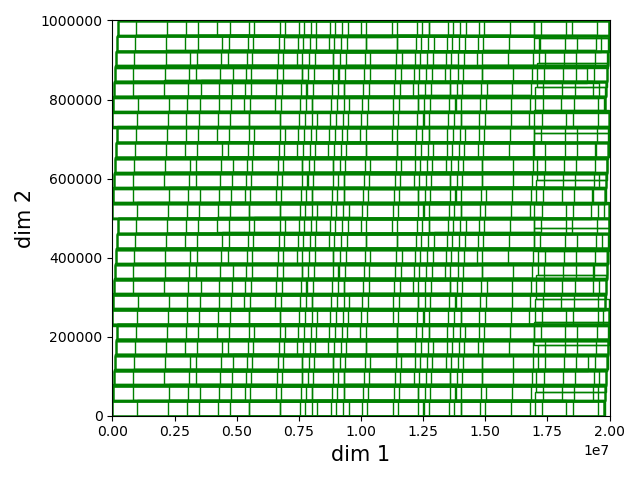

In [14]:
# = = = Visualization = = =
from Utils import *
visualize_kdnodes_and_query_2(rtree_kdnodes, [], [], domains)
# visualize_kdnodes_and_query_2(rtree_kdnodes, [], [], [[-180,180],[-90, 90]])

In [232]:
len(rtree_kdnodes)

129

In [62]:
# from Query import *
# Query(testing_set, rtree_kdnodes, random_percentage)